In [30]:
#load csv file into a pandas dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load the data
df = pd.read_excel('/home/nele_pauline_suffo/ProcessedData/quantex_at_home_data_sheet.xlsx')

df_age_group = df[["file name  (generated automatically)", "Age Group"]]
# remove the rows with missing values
df_age_group = df_age_group.dropna()

# Add .MP4 extension to file names
df_age_group["file name  (generated automatically)"] = df_age_group["file name  (generated automatically)"].astype(str) + ".MP4"

#store those two columns in a dictionary
age_group_dict = df_age_group.set_index("file name  (generated automatically)").to_dict()
age_group_dict = age_group_dict["Age Group"]

In [32]:
# Create table for age group mapping
cursor.execute("""
CREATE TABLE age_mapping (
    video_path TEXT,
    age_group INTEGER
)""")

# Insert age group mapping data into table
cursor.executemany("INSERT INTO age_mapping (video_path, age_group) VALUES (?, ?)", age_group_dict.items())
conn.commit()

In [40]:
# query sum of number of frames from all videos in database (total_frames column in VideoStatistics table)
# connect to sqlite database
import sqlite3
conn = sqlite3.connect('/home/nele_pauline_suffo/outputs/detection_pipeline_results/detection_results.db')
c = conn.cursor()

# query sum of number of frames from all videos in database
c.execute('SELECT SUM(total_frames) FROM VideoStatistics')
total_frames = c.fetchone()[0]
total_frames

19023571

In [17]:
import sqlite3
import pandas as pd

# Connect to SQLite database
conn = sqlite3.connect('/home/nele_pauline_suffo/outputs/detection_pipeline_results/detection_results.db')
cursor = conn.cursor()

# Add new column (SQLite doesn't support ALTER TABLE ADD COLUMN IF NOT EXISTS)
try:
    cursor.execute("ALTER TABLE VideoStatistics ADD COLUMN age_group INTEGER")
    conn.commit()
except sqlite3.OperationalError:
    print("Column already exists, continuing...")

In [33]:
# Update videostatistics using the age_mapping table
update_query = """
UPDATE VideoStatistics 
SET age_group = (
    SELECT am.age_group
    FROM Videos v
    JOIN age_mapping am ON v.video_path = am.video_path
    WHERE v.video_id = VideoStatistics.video_id
)
"""
cursor.execute(update_query)
conn.commit()

In [ ]:
# Verify results
verification_query = """
SELECT 
    age_group,
    COUNT(*) as video_count,
    SUM(child_count) as total_child_count,
    SUM(adult_count) as total_adult_count,
    SUM(child_face_count) as total_child_face_count,
    SUM(adult_face_count) as total_adult_face_count,
    SUM(book_count) as total_book_count,
    SUM(toy_count) as total_toy_count,
    SUM(kitchenware_count) as total_kitchenware_count,
    SUM(screen_count) as total_screen_count,
    SUM(other_object_count) as total_other_object_count,
    SUM(total_frames) as total_frames
FROM VideoStatistics
GROUP BY age_group
ORDER BY age_group;
"""

results_df = pd.read_sql(verification_query, conn)
display(results_df)

,age_group,video_count,total_child_count,total_adult_count,total_child_face_count,total_adult_face_count,total_book_count,total_toy_count,total_kitchenware_count,total_screen_count,total_other_object_count,total_frames
0,NaN,3,1457,11437,536,2315,1912,4807,85,1009,1186,153449
1,3.0,141,171816,163315,57002,67018,14489,54486,6475,1599,54847,6288561
2,4.0,158,237325,164026,33123,61690,22000,39110,5986,10156,63975,6399674
3,5.0,151,90988,168925,33916,62980,31773,69201,5772,4338,69399,6181887


In [38]:
# drop NAN age group row
quantex_counts_df = results_df.dropna(subset=["age_group"])
quantex_counts_df

,age_group,video_count,total_child_count,total_adult_count,total_child_face_count,total_adult_face_count,total_book_count,total_toy_count,total_kitchenware_count,total_screen_count,total_other_object_count,total_frames
1,3.0,141,171816,163315,57002,67018,14489,54486,6475,1599,54847,6288561
2,4.0,158,237325,164026,33123,61690,22000,39110,5986,10156,63975,6399674
3,5.0,151,90988,168925,33916,62980,31773,69201,5772,4338,69399,6181887


In [41]:
# Get the counts by age group and normalize by total frames
normalized_query = """
SELECT 
    age_group,
    CAST(SUM(child_count) AS FLOAT) / SUM(total_frames) as norm_child_count,
    CAST(SUM(adult_count) AS FLOAT) / SUM(total_frames) as norm_adult_count,
    CAST(SUM(child_face_count) AS FLOAT) / SUM(total_frames) as norm_child_face_count,
    CAST(SUM(adult_face_count) AS FLOAT) / SUM(total_frames) as norm_adult_face_count,
    CAST(SUM(toy_count) AS FLOAT) / SUM(total_frames) as norm_toy_count,
    CAST(SUM(book_count) AS FLOAT) / SUM(total_frames) as norm_book_count,
    SUM(total_frames) as total_frames,
    COUNT(DISTINCT video_id) as video_count
FROM VideoStatistics
WHERE age_group IS NOT NULL
GROUP BY age_group
ORDER BY age_group;
"""

normalized_results = pd.read_sql(normalized_query, conn)

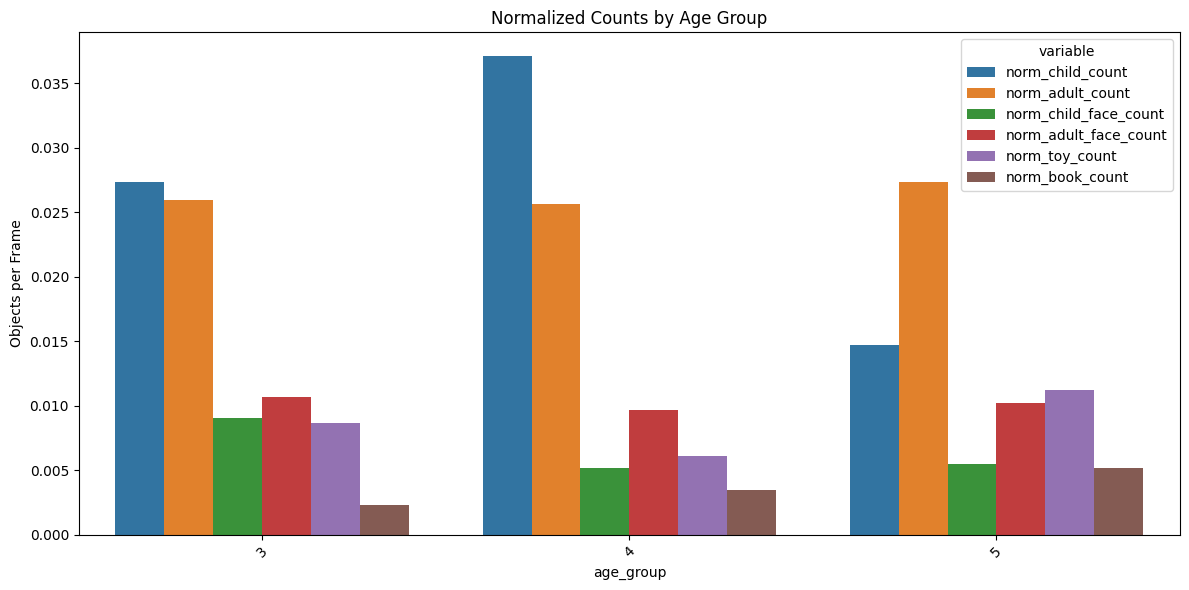

,age_group,norm_child_count,norm_adult_count,norm_child_face_count,norm_adult_face_count,norm_toy_count,norm_book_count,total_frames,video_count
0,3,0.0273,0.0260,0.0091,0.0107,0.0087,0.0023,6288561,141
1,4,0.0371,0.0256,0.0052,0.0096,0.0061,0.0034,6399674,158
2,5,0.0147,0.0273,0.0055,0.0102,0.0112,0.0051,6181887,151


In [44]:
# Create a visualization of the normalized counts
plt.figure(figsize=(12, 6))
normalized_results_melted = normalized_results.melt(
    id_vars=['age_group'], 
    value_vars=['norm_child_count', 'norm_adult_count', 'norm_child_face_count', 
                'norm_adult_face_count', 'norm_toy_count', 'norm_book_count']
)

sns.barplot(x='age_group', y='value', hue='variable', data=normalized_results_melted)
plt.title('Normalized Counts by Age Group')
plt.xticks(rotation=45)
plt.ylabel('Objects per Frame')
plt.tight_layout()
plt.show()

# Display the numerical results
display(normalized_results.round(4))

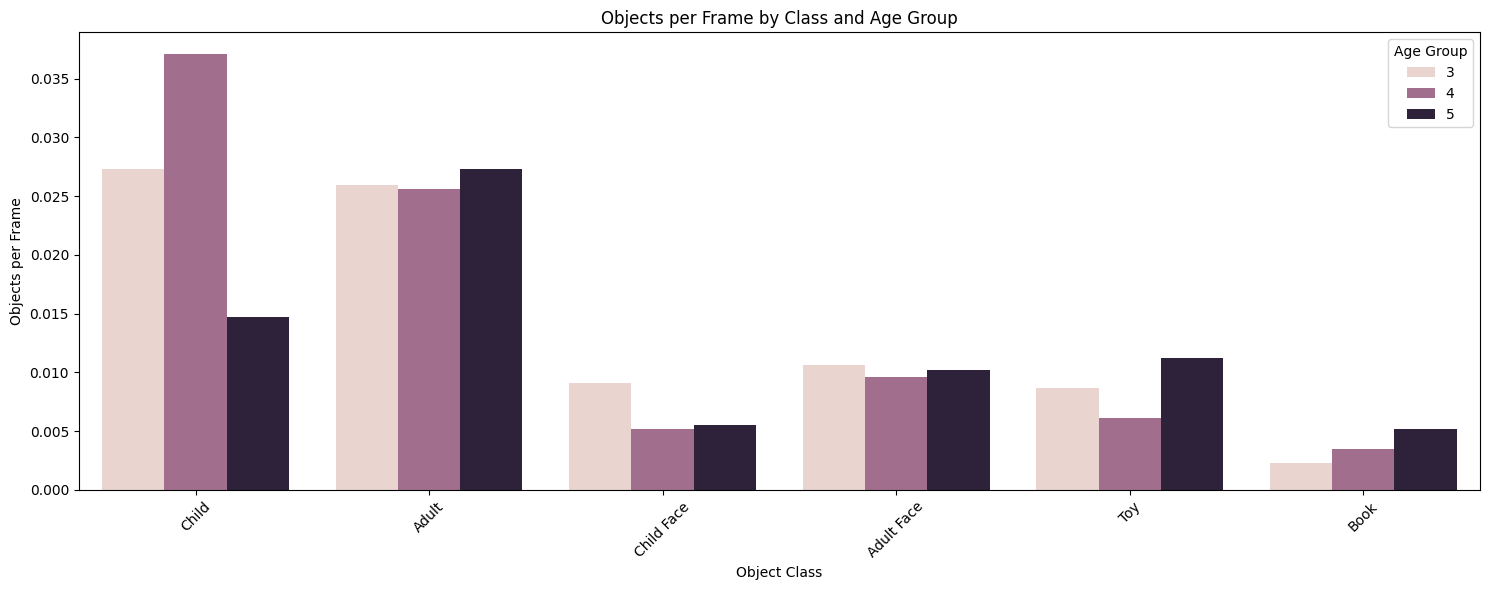

age_group,3,4,5
variable,,,
Adult,0.0260,0.0256,0.0273
Adult Face,0.0107,0.0096,0.0102
Book,0.0023,0.0034,0.0051
Child,0.0273,0.0371,0.0147
Child Face,0.0091,0.0052,0.0055
Toy,0.0087,0.0061,0.0112


In [45]:
# Prepare data for plotting
normalized_results_melted = normalized_results.melt(
    id_vars=['age_group'],
    value_vars=['norm_child_count', 'norm_adult_count', 'norm_child_face_count',
                'norm_adult_face_count', 'norm_toy_count', 'norm_book_count']
)

# Clean up labels for better readability
normalized_results_melted['variable'] = normalized_results_melted['variable'].map({
    'norm_child_count': 'Child',
    'norm_adult_count': 'Adult',
    'norm_child_face_count': 'Child Face',
    'norm_adult_face_count': 'Adult Face',
    'norm_toy_count': 'Toy',
    'norm_book_count': 'Book'
})

# Create the grouped bar plot
plt.figure(figsize=(15, 6))
sns.barplot(
    x='variable',
    y='value',
    hue='age_group',
    data=normalized_results_melted
)

plt.title('Objects per Frame by Class and Age Group')
plt.xlabel('Object Class')
plt.ylabel('Objects per Frame')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

# Display numerical results in a pivot table format for easy comparison
pivot_table = normalized_results_melted.pivot_table(
    index='variable',
    columns='age_group',
    values='value'
).round(4)
display(pivot_table)

In [ ]:
# Close connection
conn.close()